# <center>Lab11: Convolution Neural Networks </center>

---

111062697 吳律穎

# 1. Prepare Dataset

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

2023-11-07 03:23:17.710892: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 03:23:17.710976: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 03:23:17.719828: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#下載 dataset.zip
# !wget --load-cookies /tmp/gcookie.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/gcookie.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1HncttRdMHeNjde8xQCjQQtTLG8dcaTJx' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1HncttRdMHeNjde8xQCjQQtTLG8dcaTJx" -O oregon_wildlife.zip && rm -f /tmp/gcookie.txt


In [3]:
# You need to download the prepared data and unzip the file in current path('./')
%cd /home/s111062697/deep_learning/lecture11/homework

data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

/home/s111062697/deep_learning/lecture11/homework
classes:
oregon_wildlife/red_fox
oregon_wildlife/raven
oregon_wildlife/cougar
oregon_wildlife/raccoon
oregon_wildlife/bald_eagle
oregon_wildlife/black_bear
oregon_wildlife/virginia_opossum
oregon_wildlife/deer
oregon_wildlife/sea_lions
oregon_wildlife/nutria

total img num: 7168


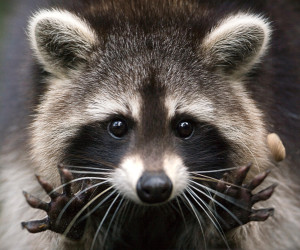

raccoon


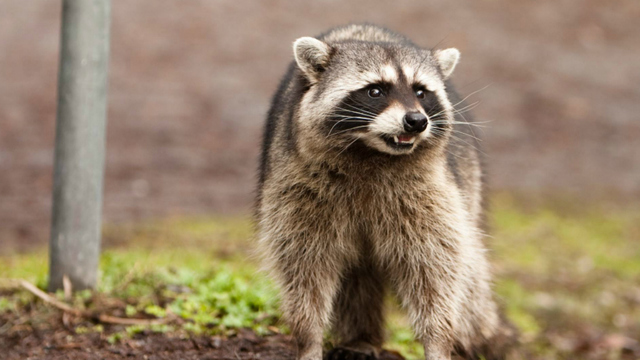

raccoon


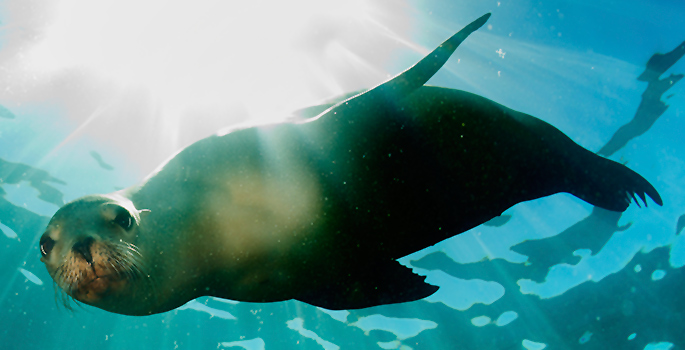

sea_lions


In [4]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [5]:
# get the label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [6]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [7]:
# get the label data
all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [8, 1, 2, 1, 7, 2, 6, 7, 6, 7]


In [8]:
# Create training and testing sets using an 80-20 split
img_path_train, img_path_test, label_train, label_test = train_test_split(all_image_paths,
                                all_image_label,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_test)))

training data: 5734
testing data: 1434


In [9]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

# 2. Data Loader

In [10]:
# Feel free to change IMAGE_SIZE_CROPPED if using random_crop in your data augmentation process, but make sure the input resize back to (300,300,3) before feed into VGG16
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [11]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------
        
        # Reading the file        
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [12]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('test.csv', open_file, read_file)

In [13]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 32

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).batch(BATCH_SIZE, drop_remainder=True)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[2.7143877e+03 1.1124196e-01]
 [2.7144988e+03 1.4676115e-01]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 0  0 -1]
 [ 0  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


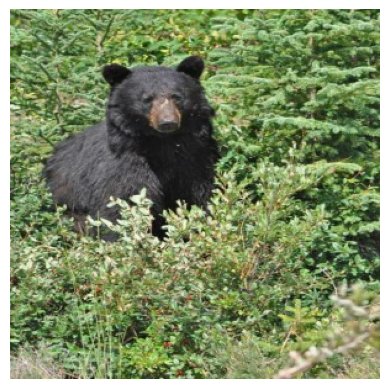

black_bear


In [14]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

# 3. Build  Model

In [15]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [16]:
wild_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [17]:
# save the initialization of weights 
wild_model.save_weights('wild_model.h5')

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [19]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)
    
@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

# 4. Train and Validate

In [20]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter
            
            time.sleep(0.05)
            
            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter
            
            time.sleep(0.05)
            
            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)
            
        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [21]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=3)

start time:  2721.212143958
training:


  0%|          | 0/179 [00:00<?, ?it/s]

100%|██████████| 179/179 [09:31<00:00,  3.19s/it]

testing:



100%|██████████| 44/44 [02:00<00:00,  2.74s/it]

Epoch 1, Loss: 3.9577, Accuracy: 32.2277, test Loss: 1.1109, test Accuracy: 67.5426
training:



 75%|███████▍  | 134/179 [07:31<02:30,  3.35s/it]

i. Without data transformation and pipeline optimization

In [ ]:
draw_timeline(timeline=timeline_Naive, title="Naive", min_width=3000)

ii. With data transformation

1. Shuffle the data before batching them.
2. Apply random flip (left or right), random brightness, random contrast, and standardization on training images, but only apply standardization on testing images.

# parse training data
@tf.function
def map_fun(steps, times, values, image, label):
    map_enter = time.perf_counter()

    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
        distorted_image,\
        label

# parse testing data
@tf.function
def map_fun_test(steps, times, values, image, label):
    map_enter = time.perf_counter()

    distorted_image = tf.image.per_image_standardization(image)

    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
        distorted_image,\
        label

In [ ]:
## TODO: build `dataset_train_augmentation` and `dataset_test_augmentation` with transformation
## Remember to define your own map functions with map_decorator before calling map

dataset_train_augmentation = tf.data.Dataset.range(1)\
                                            .flat_map(dataset_generator_fun_train)\
                                            .shuffle(BUFFER_SIZE)\
                                            .batch(BATCH_SIZE, drop_remainder=True)\
                                            .map(map_fun)

dataset_test_augmentation = tf.data.Dataset.range(1)\
                                           .flat_map(dataset_generator_fun_val)\
                                           .batch(BATCH_SIZE, drop_remainder=True)\
                                           .map(map_fun_test)

In [ ]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(
    dataset_train_augmentation, dataset_test_augmentation)

In [ ]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=3000)

iii. With data transformation and pipeline optimization

In [ ]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated
dataset_train_optimized = tf.data.Dataset.range(1)\
                                         .interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                         .shuffle(BUFFER_SIZE)\
                                         .batch(BATCH_SIZE, drop_remainder=True)\
                                         .map(map_fun, num_parallel_calls=tf.data.AUTOTUNE)\
                                         .cache()\
                                         .prefetch(tf.data.AUTOTUNE)

dataset_test_optimized = tf.data.Dataset.range(1)\
                                        .interleave(dataset_generator_fun_val, num_parallel_calls=tf.data.AUTOTUNE)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .map(map_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                        .cache()\
                                        .prefetch(tf.data.AUTOTUNE)

In [ ]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(
    dataset_train_optimized, dataset_test_optimized)

In [ ]:
draw_timeline(timeline_Optimized, "Optimized", 500)